# (1) Imports 

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import os
import itertools
from typing import List, Tuple, Dict, Any
from pathlib import Path

# (2) Define file paths and files with inverted data. Create a pandas dataframe with expected values

In [66]:
def get_csv_paths(directory: Path, exclude: list) -> list:
    """
    Retrieve paths to all CSV files in a directory excluding specified files.

    :param directory: The directory to search for CSV files (as a Path object).
    :param exclude: A list of filenames to exclude from the results.
    :return: A list of paths to the CSV files.
    """
    return [file for file in directory.glob('*.csv') if file.name not in exclude]

# Define the directory containing the CSV files and any files to exclude
directory = Path(r'C:\Users\lmogg\Documents\electronRx\eRxCardio Challenge_4.1')
exclude_files = ['expected_results.csv']

# Get a list of CSV paths, excluding specified files
csv_paths = get_csv_paths(directory, exclude_files)

# Paths to files that require inversion (from initial inspection if data)
invert_files = {
    "2022-06-14 09-31-19.csv",
    "2022-06-14 09-42-01.csv",
    "2022-06-14 11-07-24.csv",
    "2022-06-14 11-55-02.csv",
    "2022-06-14 12-55-43.csv"
}

# Convert expected data to a DataFrame
expected_file = directory / exclude_files[0]
expected_df = pd.read_csv(expected_file)
expected_df['File'] = expected_df['File'].astype(str) + '.csv'

# Folder to save plots
output_folder = r'C:/Users/lmogg/Documents/electronRx/Coding Challenge Figures/Red Plots'
os.makedirs(output_folder, exist_ok=True)


# (3) Functions to load, process and plot data

In [67]:
def calculate_time_diff(df: pd.DataFrame) -> pd.Series:
    """
    Calculate time differences between successive entries in the 'time' column of the DataFrame.
    """
    return df['time'].diff()

def find_gap_indices(time_diff: pd.Series, gap_threshold: float) -> list:
    """
    Find the indices where time difference exceeds the given gap threshold.
    """
    return time_diff[time_diff > gap_threshold].index.tolist()

def shift_time_values(df: pd.DataFrame, gap_indices: list, restart_after: float) -> None:
    """
    Adjust the 'time' values in the DataFrame for all entries after each detected gap.
    """
    for gap_index in gap_indices:
        last_time_before_gap = df.loc[gap_index - 1, 'time']
        shift_start_time = last_time_before_gap + restart_after
        shift_amount = shift_start_time - df.loc[gap_index, 'time']
        df.loc[gap_index:, 'time'] += shift_amount

def save_adjusted_df(df: pd.DataFrame, csv_path: str) -> str:
    """
    Save the adjusted DataFrame to a CSV file, and return the path of the saved file.
    """
    output_folder = r'C:\Users\lmogg\Documents\electronRx\Shifted Datasets'
    os.makedirs(output_folder, exist_ok=True)
    base_filename = os.path.basename(csv_path)
    new_filename = f"shifted_{base_filename}"
    output_path = os.path.join(output_folder, new_filename)
    df.to_csv(output_path)
    return output_path

def shift_data_after_gap(df: pd.DataFrame, csv_path: str, gap_threshold: float = 2.0, restart_after: float = 0.8) -> pd.DataFrame:
    """
    Detects gaps in the time series and shifts the 'time' values after the gap.
    The time for subsequent data points is shifted to start 0.8 seconds after the last point before the gap.
    """
    time_diff = calculate_time_diff(df)
    gap_indices = find_gap_indices(time_diff, gap_threshold)
    if gap_indices:
        shift_time_values(df, gap_indices, restart_after)
    save_adjusted_df(df, csv_path)
    return df


def savgol_and_normalize(series, window_length=5, polyorder=1):
    if window_length % 2 == 0 or window_length >= len(series):
        raise ValueError("Window length must be an odd number and less than the length of the series.")
    trend = savgol_filter(series, window_length=window_length, polyorder=polyorder)
    detrended_series = series - trend
    normalized_series = (detrended_series - detrended_series.min()) / (detrended_series.max() - detrended_series.min())
    return normalized_series


def adaptive_detrend(series, window_size=5):
    trend = series.rolling(window=window_size, min_periods=1, center=True).mean()
    detrended_series = series - trend
    return detrended_series


def detect_prominent_peaks(signal, prominence=0.19, height=0.005):
    peaks, properties = find_peaks(signal, prominence=prominence, height=height)
    return peaks, properties

def read_data(path: str) -> pd.DataFrame:
    """
    Reads a CSV file into a DataFrame.
    """
    return pd.read_csv(path, index_col=0)

def invert_signal(df: pd.DataFrame, column: str) -> None:
    """
    Inverts the signal of the specified column in the DataFrame.
    """
    df[column] = -1 * df[column]

def process_signal(df: pd.DataFrame, apply_detrending: bool, window_size: int, window_length: int, polyorder: int) -> None:
    """
    Processes the signal by applying detrending and Savitzky-Golay filtering.
    """
    if apply_detrending:
        df["Red"] = adaptive_detrend(df["Red"], window_size=window_size)
        df["Red"] = savgol_and_normalize(df["Red"], window_length=window_length, polyorder=polyorder)

def detect_peaks(df: pd.DataFrame, prominence: float, height: float) -> tuple:
    """
    Detects peaks in the 'Red' column of the DataFrame.
    """
    peaks, _ = detect_prominent_peaks(df["Red"], prominence=prominence, height=height)
    return peaks, df.index[peaks], df["Red"][peaks]

def load_and_process_data_with_params(csv_paths, invert_files, apply_detrending=True, fs=75, peak_prominence=0.124,
                                      peak_height=0.1, window_length=81, polyorder=1, window_size=101):
    dataframes = []
    peaks_info = []

    for path in csv_paths:
        try:
            df = read_data(path)
            base_filename = os.path.basename(path)

            # Select out the red channel (can be modified to
            if "Red" in df.columns and "time" in df.columns:
                df = shift_data_after_gap(df, csv_path=path)

                if base_filename in invert_files:
                    invert_signal(df, "Red")

                process_signal(df, apply_detrending, window_size, window_length, polyorder)

                peaks = detect_peaks(df, peak_prominence, peak_height)
                peaks_info.append((base_filename, peaks[1], peaks[2]))
            else:
                print(f'"Red" or "time" column not found in {path}')
                peaks_info.append((base_filename, [], []))

            dataframes.append(df)
        except Exception as e:
            print(f"Error loading CSV file {path}: {e}")
            peaks_info.append((base_filename, [], []))

    return dataframes, peaks_info

def plot_channel_with_peaks(dataframes: List[pd.DataFrame], peaks_info: List[Tuple[str, List[int], List[float]]],
                            csv_paths: List[str], output_folder: str, channel: str = "Red") -> None:
    """
    Plots a specified channel from each DataFrame in a list along with detected peaks in a 5x2 grid layout.

    :param dataframes: List of DataFrames containing the time series data.
    :param peaks_info: List of tuples containing filenames and peak information.
    :param csv_paths: List of paths to the CSV files corresponding to each DataFrame.
    :param output_folder: Path to save the output plots.
    :param channel: Name of the channel to plot, defaults to 'Red'.
    """
    num_plots = min(len(dataframes), 10)  # Limit to maximum of 10 plots for a 5x2 grid
    plt.figure(figsize=(20, 12))  # Adjust figure size to accommodate the grid layout

    for i in range(num_plots):
        filename, df = csv_paths[i], dataframes[i]
        peak_filename, peak_indices, peak_values = peaks_info[i]

        if "time" in df.columns and channel in df.columns:
            ax = plt.subplot(5, 2, i + 1)  # Create a subplot in a 5x2 grid
            ax.plot(df["time"], df[channel], label=channel, color="red")

            if peak_filename == os.path.basename(filename):
                ax.plot(df["time"][peak_indices], peak_values, "x", label="Detected Peaks", color="blue")

            ax.set_title(f"{os.path.basename(filename)} - {channel}")
            ax.set_xlabel("Time (seconds)")
            ax.set_ylabel("Signal Value")
            ax.legend()
            ax.grid(True)

        else:
            print(f'Missing "time" or "{channel}" column in {filename}.')

    plt.tight_layout()  # Adjust the layout to make sure there's no overlap
    output_path = os.path.join(output_folder, f"combined_{channel}_processed_peaks_plot.png")
    plt.savefig(output_path)
    plt.show()

# (4) Functions to extract heart rate metrics 

In [68]:
def calculate_hr(num_peaks: int, duration: float) -> float:
    """
    Calculate heart rate (HR) from the number of peaks and measurement duration.
    """
    return num_peaks * (60 / duration)

def calculate_ibi(peak_indices: np.ndarray, sampling_rate: float) -> np.ndarray:
    """
    Calculate the inter-beat intervals (IBIs) from peak indices.
    """
    return np.diff(peak_indices / sampling_rate)

def calculate_rmssd(ibi: np.ndarray) -> float:
    """
    Calculate the root mean square of successive differences (rMSSD) of IBIs.
    """
    ibi_diffs = np.diff(ibi)
    if len(ibi_diffs) > 0:
        return np.sqrt(np.mean(np.power(ibi_diffs, 2))) * 1000
    return np.nan

def calculate_sdnn(ibi: np.ndarray) -> float:
    """
    Calculate the standard deviation of NN intervals (SDNN).
    """
    return np.std(ibi) * 1000

def calculate_pnn50(ibi_diffs: np.ndarray) -> float:
    """
    Calculate the percentage of successive NN interval differences greater than 50 ms.
    """
    differences_greater_than_50ms = np.where(np.abs(ibi_diffs) > 0.05)[0]
    if len(ibi_diffs) > 0:
        return len(differences_greater_than_50ms) / len(ibi_diffs) * 100
    return np.nan

def calculate_heart_metrics(peaks_info: List[Tuple[str, List[int], List[float]]], sampling_rate: float = 75) -> pd.DataFrame:
    """
    Extracts HR, rMSSD, SDNN, and pNN50 metrics from peaks_info.
    """
    results: List[Dict[str, float]] = []

    for filename, peak_indices, _ in peaks_info:
        if filename == "2022-06-07 11-22-35.csv":
            measurement_duration_seconds = 57.58  # Measurement stops at 40 seconds for this file
        else:
            measurement_duration_seconds = 60  # Default to 60-second measurement

        num_peaks = len(peak_indices)
        hr = calculate_hr(num_peaks, measurement_duration_seconds)

        if num_peaks > 1:
            ibi = calculate_ibi(np.array(peak_indices), sampling_rate)
            rMSSD = calculate_rmssd(ibi)
            SDNN = calculate_sdnn(ibi)
            ibi_diffs = np.diff(ibi)
            pNN50 = calculate_pnn50(ibi_diffs)
        else:
            rMSSD, SDNN, pNN50 = np.nan, np.nan, np.nan

        results.append({
            'File': filename,
            'HR': hr,
            'rMSSD': rMSSD,
            'SDNN': SDNN,
            'pNN50': pNN50
        })

    return pd.DataFrame(results)

def get_user_input(prompt: str) -> bool:
    """
    Prompt the user for a yes/no input and return a boolean.
    """
    response = input(prompt).strip().lower()
    return response == 'y'

def load_and_analyze_data(csv_paths: List[str], invert_files: List[str], apply_detrending: bool) -> Tuple[List[pd.DataFrame], List[Tuple[str, List[int], List[float]]]]:
    """
    Load data, apply processing, and extract peaks.
    """
    dataframes, peaks_info = load_and_process_data_with_params(csv_paths, invert_files, apply_detrending)
    return dataframes, peaks_info

def plot_data(dataframes: List[pd.DataFrame], peaks_info: List[Tuple[str, List[int], List[float]]], csv_paths: List[str], output_folder: str, channel: str = "Red") -> None:
    """
    Plot the specified channel with detected peaks.
    """
    plot_channel_with_peaks(dataframes, peaks_info, csv_paths, output_folder, channel)

def calculate_and_compare_metrics(peaks_info: List[Tuple[str, List[int], List[float]]], expected_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, float]:
    """
    Calculate heart metrics from peaks_info, compare with expected values, and calculate differences.

    :param peaks_info: List of tuples with the format (filename, peak_indices, peak_values).
    :param expected_df: DataFrame containing expected heart metrics with a 'File' column.
    :return: Tuple containing DataFrames for calculated metrics, expected metrics, differences, and the cumulative error.
    """
    heart_metrics_df = calculate_heart_metrics(peaks_info)
    
    # Merge calculated and expected metrics for comparison
    comparison_df = pd.merge(expected_df, heart_metrics_df, on="File", suffixes=("_Expected", "_Calculated"))

    # Calculate differences for each metric
    difference_df = comparison_df.copy()
    for metric in ["HR", "rMSSD", "SDNN", "pNN50"]:
        difference_df[f"{metric}_Difference"] = np.round(comparison_df[f"{metric}_Calculated"] - comparison_df[f"{metric}_Expected"], 4)

    # Select columns to show only differences along with file names
    difference_columns = ["File"] + [f"{metric}_Difference" for metric in ["HR", "rMSSD", "SDNN", "pNN50"]]
    difference_df = difference_df[difference_columns]

    # Calculate cumulative error across all metrics
    cumulative_error = difference_df[[col for col in difference_df.columns if col != "File"]].abs().sum().sum()

    return heart_metrics_df, expected_df, difference_df, cumulative_error
    

def print_dataframe(title: str, df: pd.DataFrame) -> None:
    """
    Print the DataFrame with a title and formatted borders.
    
    :param title: Title of the DataFrame to be printed.
    :param df: DataFrame to print.
    """
    print(f"\n{title}\n{'=' * len(title)}")
    print(df.to_string(index=False))  # Use to_string for better control over printing

def print_cumulative_error(cumulative_error: float) -> None:
    """
    Print the cumulative error with formatting.
    
    :param cumulative_error: The calculated cumulative error to print.
    """
    print("\nCumulative Error:")
    print(f"{cumulative_error:.4f}")  # Format for consistency

# (5) Main Script Execution

Apply detrending? (y/n):  y


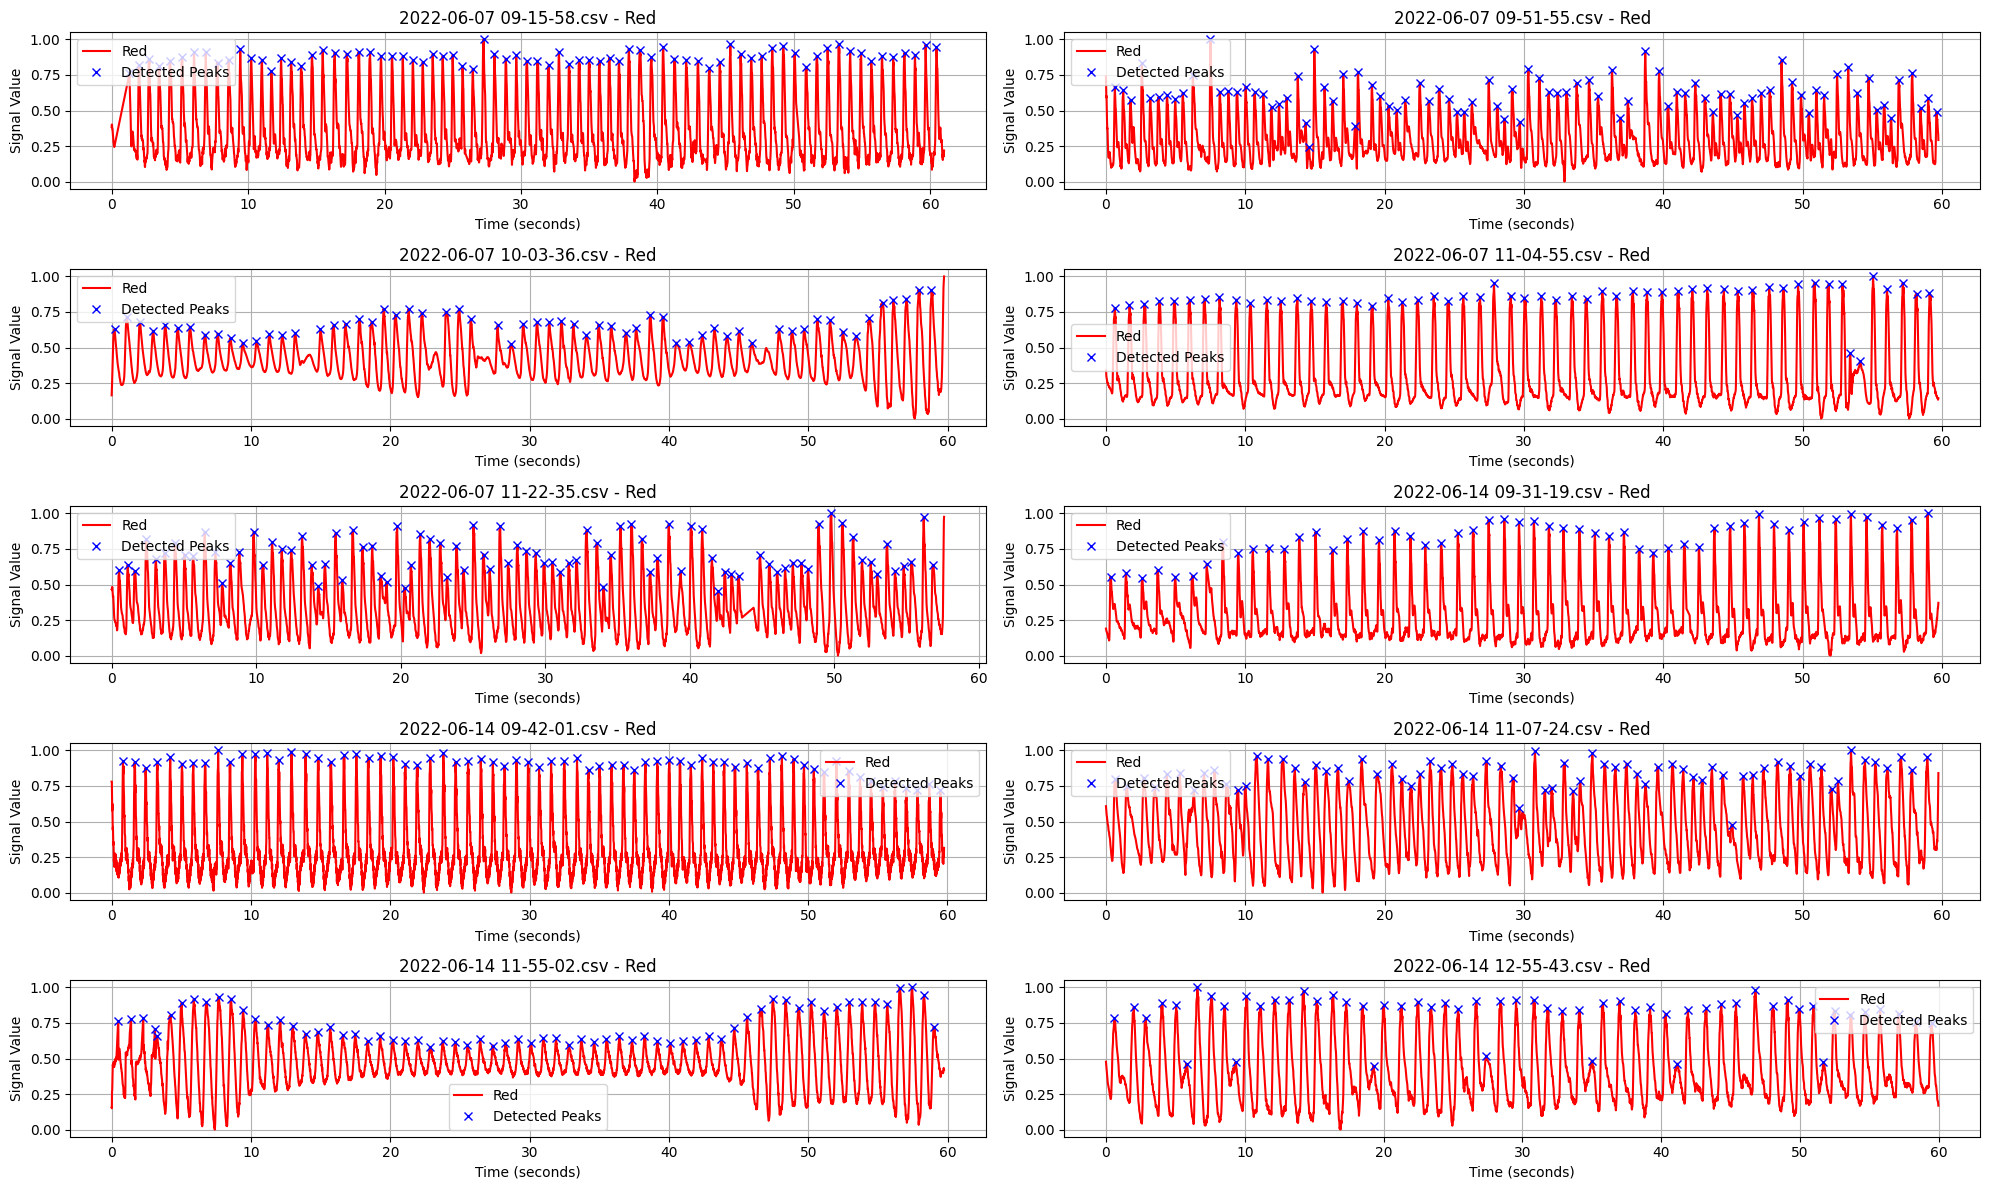


Fitted Values DataFrame
                   File        HR      rMSSD       SDNN     pNN50
2022-06-07 09-15-58.csv 76.000000  72.996771  64.801402 32.432432
2022-06-07 09-51-55.csv 90.000000 260.419242 181.598124 71.590909
2022-06-07 10-03-36.csv 61.000000 364.797496 245.607234 67.796610
2022-06-07 11-04-55.csv 56.000000 144.313331 115.138500 77.777778
2022-06-07 11-22-35.csv 93.782563 162.561566 116.224947 78.409091
2022-06-14 09-31-19.csv 54.000000  99.055367  71.173186 61.538462
2022-06-14 09-42-01.csv 70.000000  69.451634  62.041325 50.000000
2022-06-14 11-07-24.csv 73.000000 205.939961 156.546666 81.690141
2022-06-14 11-55-02.csv 67.000000 146.124873 101.981591 23.076923
2022-06-14 12-55-43.csv 58.000000 255.112798 185.562697 91.071429

Expected Values DataFrame
                   File        HR      rMSSD       SDNN     pNN50
2022-06-07 09-15-58.csv 75.996156  43.125746  50.051427 30.136986
2022-06-07 09-51-55.csv 88.322115 219.242426 165.595543 68.235294
2022-06-07 10-03-36.csv 

In [69]:
# Main script execution
apply_detrending = get_user_input("Apply detrending? (y/n): ")
dataframes, peaks_info = load_and_analyze_data(csv_paths, invert_files, apply_detrending)
plot_data(dataframes, peaks_info, csv_paths, output_folder)
heart_metrics_df, expected_df, difference_df, cumulative_error = calculate_and_compare_metrics(peaks_info, expected_df)

# Output results using the defined print functions
print_dataframe("Fitted Values DataFrame", heart_metrics_df)
print_dataframe("Expected Values DataFrame", expected_df)
print_dataframe("Differences between Fiited and Expected DataFrame", difference_df)
print_cumulative_error(cumulative_error)

# (6) Parameter Optimisation: Search over input paramaters to minimise fitted to expected data

In [70]:
# Define the parameter ranges
def define_parameter_ranges() -> List[List[Any]]:
    return [
        [0.124, 0.123, 0.125, 0.126, 0.127],  # peak_prominence_range
        [0.0005, 0.0006, 0.0007, 0.0004, 0.0003],  # peak_height_range
        [77, 79, 81, 83, 85, 87],  # window_length_range
        [1],  # polyorder_range
        [101, 111, 121, 131, 141]  # window_size_range
    ]

# Generate all parameter combinations
def generate_parameter_combinations(ranges: List[List[Any]]) -> List[Tuple[Any, ...]]:
    return list(itertools.product(*ranges))

# Calculate the cumulative error for a given parameter set
def calculate_cumulative_error(params: Tuple[float, float, int, int, int], csv_paths: List[str], invert_files: List[str], expected_df: pd.DataFrame) -> float:
    peak_prominence, peak_height, window_length, polyorder, window_size = params

    # Process data with these parameters
    dataframes, peaks_info = load_and_process_data_with_params(
        csv_paths, invert_files, apply_detrending=True, fs=75,
        peak_prominence=peak_prominence, peak_height=peak_height,
        window_length=window_length, polyorder=polyorder, window_size=window_size
    )

    # Calculate the heart metrics
    heart_metrics_df = calculate_heart_metrics(peaks_info)

    # Merge expected and calculated results for comparison
    comparison_df = pd.merge(expected_df, heart_metrics_df, on="File", suffixes=("_Expected", "_Calculated"))

    # Calculate differences and cumulative absolute error
    for metric in ["HR", "rMSSD", "SDNN", "pNN50"]:
        comparison_df[f"{metric}_Difference"] = np.round(comparison_df[f"{metric}_Calculated"] - comparison_df[f"{metric}_Expected"], 4)
    cumulative_error = comparison_df[[f"{metric}_Difference" for metric in ["HR", "rMSSD", "SDNN", "pNN50"]]].abs().sum().sum()

    return cumulative_error

# Find the optimal parameters based on the cumulative error
def find_optimal_parameters(results: List[Tuple[Tuple[Any, ...], float]]) -> Tuple[Tuple[Any, ...], float]:
    return min(results, key=lambda x: x[1])

# Main function to run the grid search
def run_grid_search(csv_paths: List[str], invert_files: List[str], expected_df: pd.DataFrame) -> None:
    parameter_ranges = define_parameter_ranges()
    param_combinations = generate_parameter_combinations(parameter_ranges)
    results = [(params, calculate_cumulative_error(params, csv_paths, invert_files, expected_df)) for params in param_combinations]

    optimal_params, min_error = find_optimal_parameters(results)

    print("Optimal parameters:", optimal_params)
    print("Cumulative error:", min_error)

run_grid_search(csv_paths, invert_files, expected_df)

Optimal parameters: (0.124, 0.0005, 87, 1, 101)
Cumulative error: 1060.6964999999998
